$$\Huge\textbf{Decision Tree Models}$$

# Imports

In [35]:
# Standard library imports
import os  # directory and file operations
import shutil  # copying files
import time  # adding delays

# Installed library imports
import cv2  #  OpenCV for computer vision tasks
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # plotting and visualization
import pandas as pd
from PIL import Image  # image processing
import seaborn as sns  # confusion matrix visualization
from skimage import exposure  #  scikit-image for image processing tasks
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report  # evaluation metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split  # splitting datasets and cross-validation
from sklearn.tree import DecisionTreeClassifier  # decision tree classifier
import torchvision.transforms as transforms  # data augmentation
from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split# splitting data into labeled and unlabeled for semi-dt 
from tqdm import tqdm # wrapping around the iterable that processes the image files
from skimage.color import rgb2gray # Converting image to grayscale
from skimage.feature import hog # HOG feature extraction

# Global Constansts

In [3]:
# constants
NUM_IMAGES_PER_CLASS = 1000
TEST_SPLIT_PERCENTAGE = 0.15
TRAIN_VAL_SPLIT_PERCENTAGE = 1 - TEST_SPLIT_PERCENTAGE  # the rest is for training and validation
BATCH_SIZE = 100  # number of images to copy at once
RANDOM_SEED = 42  # seed for reproducibility

IMAGE_SIZE = (256, 256)
VALIDATION_SPLIT = 15 / 85  # train_val is 85% of the total dataset, we want the validation set to be 15% of the total dataset
CLASSES = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']

In [ ]:
# data directories
# need to modify the PROJECT_DATASET_DIR and PROJECT_OUTPUT_DIR to your own address
PROJECT_DATASET_DIR = '/content/drive/MyDrive/project_dataset'
PROJECT_OUTPUT_DIR = '/content/drive/MyDrive/project_output'
CLASSES_ORIGINAL = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
CLASSES_NEW = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
PROCESSED_DATA_DIR = os.path.join(PROJECT_DATASET_DIR, 'processed_data')

NO_CV_TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation','train') 
NO_CV_VAL_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'validation')  
NO_CV_TEST_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'test')  
CV_DIR = os.path.join(PROCESSED_DATA_DIR, 'with_cross_validation') 

In [4]:
# please do not remove it, it's for test purpose!!

# processed data directories: case without cross validation
PROCESSED_DATA_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data'
TEST_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'test')
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation','train') 
VALIDATION_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'validation')  # new directory

# project output directory
PROJECT_OUTPUT_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output'
output_path = r"C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output\eval_results_grid_search.txt"
output_path_filetest = r"C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output\best_result_basic_DT.txt"

output_path_file_edge_hog = r"C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output\best_result_DT_edge_hog.txt"



# 1. Help Functions

## 1.1. Load image data and labels for each dataset

In [5]:
# function without adding any transformation when loading the images
def load_images_and_labels(base_dir):
    """
    Load image data and labels from a specified directory. This function traverses each class directory, loads each image, and assigns labels based on the directory name.

    Inputs:
    - base_dir: A string, the path to the directory containing subdirectories for each class.

    Outputs:
    - A tuple containing two numpy arrays:
      1. `data`: an array of flattened image data.
      2. `labels`: an array of labels corresponding to the images.

    Each class is expected to have its own subdirectory within `base_dir` with the name of the class.
    """
    # Initialize lists to store image data and labels
    data = []
    labels = []

    # Define the classes and create a mapping from class names to a unique integer
    classes = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
    class_labels = {cls_name: idx for idx, cls_name in enumerate(classes)}

    # Iterate over each class directory in the base directory
    for cls_name in classes:
        class_dir = os.path.join(base_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)  # Open the image directly
            img_data = np.array(img).flatten()  # Flatten the image data into a one-dimensional vector
            data.append(img_data)
            labels.append(class_labels[cls_name])

    # Convert the lists of data and labels to numpy arrays and return
    return np.array(data), np.array(labels)

## 1.2. Generate CSV file

In [ ]:
def generate_csv_filename(max_depth, min_samples_split, min_samples_leaf, criterion):
    """
    Generate a filename for storing CSV data based on the parameters of a decision tree model.

    Parameters:
    - max_depth (int or None): The maximum depth of the tree.
    - min_samples_split (int): The minimum number of samples required to split an internal node.
    - min_samples_leaf (int): The minimum number of samples required to be at a leaf node.
    - criterion (str): The function to measure the quality of a split.

    Returns:
    - str: A string representing the filename.
    """
    # Replace None with 'None' for filename compatibility
    max_depth_str = 'None' if max_depth is None else max_depth

    # Construct the filename
    filename = f"d{max_depth_str}_s{min_samples_split}_l{min_samples_leaf}_{criterion}.csv"

    return filename

# 2. Evaluation Metrics

In [29]:
def evaluate_model(predictions, true_labels):
    """
    Evaluate the predictions of a model using the true labels.
    Calculate the accuracy, precision, recall, and confusion matrix of the predictions.

    Inputs:
    - predictions (np.ndarray): The predicted labels from the model.
    - true_labels (np.ndarray): The true labels for the validation data.

    Outputs:
    - accuracy (float): The accuracy of the model on the validation data.
    - precision (float): The precision of the model on the validation data.
    - recall (float): The recall of the model on the validation data.
    - f1 (float): The f1-score of the model on the validation data.
    - conf_matrix (np.ndarray): The confusion matrix of the model's predictions.
    - report (str): The classification report of the model's predictions.
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    # Calculate precision (macro-average for multi-class classification)
    precision = precision_score(true_labels, predictions, average='macro')
    
    # Calculate recall (macro-average for multi-class classification)
    recall = recall_score(true_labels, predictions, average='macro')
    
    # Calculate f1-score (macro-average for multi-class classification)
    f1 = f1_score(true_labels, predictions, average='macro')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Generate classification report
    report = classification_report(true_labels, predictions)

    return accuracy, precision, recall, f1, conf_matrix, report


In [30]:
## version with seaborn, display issues, to be fixed
def plot_binary_confusion_matrix(true_labels, predictions, class_index, class_label):
    """
    Plot the binary confusion matrix for a specific class.

    Inputs:
    - true_labels (np.ndarray): The true labels for the validation data.
    - predictions (np.ndarray): The predicted labels from the model.
    - class_index (int): The index of the class to plot.
    - class_label (str): The label of the class to plot.
    """
    binary_true_labels = (true_labels == class_index).astype(int)
    binary_predictions = (predictions == class_index).astype(int)
    
    binary_conf_matrix = confusion_matrix(binary_true_labels, binary_predictions)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(binary_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not ' + class_label, class_label], yticklabels=['Not ' + class_label, class_label])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Binary Confusion Matrix for {class_label}')
    plt.show()
    

In [22]:
def print_binary_confusion_matrix(true_labels, predictions, class_index, class_label):
    """
    Print the binary confusion matrix for a specific class.

    Inputs:
    - true_labels (np.ndarray): The true labels for the validation data.
    - predictions (np.ndarray): The predicted labels from the model.
    - class_index (int): The index of the class to print.
    - class_label (str): The label of the class to print.
    """
    binary_true_labels = (true_labels == class_index).astype(int)
    binary_predictions = (predictions == class_index).astype(int)
    
    binary_conf_matrix = confusion_matrix(binary_true_labels, binary_predictions)
    
    tn, fp, fn, tp = binary_conf_matrix.ravel()
    
    print(f'Binary Confusion Matrix for {class_label}:')
    print(f'True Negatives (TN): {tn}')
    print(f'False Positives (FP): {fp}')
    print(f'False Negatives (FN): {fn}')
    print(f'True Positives (TP): {tp}')
    print(binary_conf_matrix)
    print('[[TN, FP],')
    print(' [FN, TP]]')

In [31]:
def print_evaluation_results(results, true_labels, predictions):
    """
    Print and plot the evaluation results.

    Inputs:
    - results (tuple): A tuple containing the following evaluation results:
        - accuracy (float): The accuracy of the model.
        - precision (float): The precision of the model.
        - recall (float): The recall of the model.
        - f1 (float): The f1-score of the model.
        - conf_matrix (np.ndarray): The confusion matrix of the model's predictions.
        - report (str): The classification report of the model's predictions.
    - true_labels (np.ndarray): The true labels for the validation data.
    - predictions (np.ndarray): The predicted labels from the model.

    No outputs. The function prints the evaluation metrics and plots the confusion matrix.
    """
    # Unpack the results tuple
    accuracy, precision, recall, f1, conf_matrix, report = results

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

    print("Classification Report:")
    print(report)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Plot the overall confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Overall Confusion Matrix')
    plt.show()

    # Plot binary confusion matrix for each class
    for i, class_label in enumerate(CLASSES):
        plot_binary_confusion_matrix(true_labels, predictions, i, class_label)
        #print_binary_confusion_matrix(true_labels, predictions, i, class_label)



In [9]:
def save_evaluation_results_to_txt(results, filename, hyperparameters, dataset):
    """
    Save evaluation results to a text file.

    Parameters:
    - results (tuple): A tuple containing accuracy, precision, recall, f1, confusion matrix, and classification report.
    - filename (str): Full path of the text file to save the results.
    - hyperparameters (dict): The hyperparameters used for the model.
    - dataset (str): The dataset on which the model was evaluated ('Training' or 'Validation').
    """
    accuracy, precision, recall, f1, conf_matrix, report = results

    with open(filename, 'a') as file:
        file.write(f"Evaluation Results on {dataset} Data:\n")
        for key, value in hyperparameters.items():
            file.write(f"{key}: {value}\n")
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"Precision: {precision}\n")
        file.write(f"Recall: {recall}\n")
        file.write(f"F1 Score: {f1}\n")
        file.write(f"Confusion Matrix:\n{conf_matrix}\n")
        file.write(f"Classification Report:\n{report}\n")
        file.write("\n")

# 3. Additional Data Preprocessing on Training Set

## 3.1. Feature Reduction: PCA

In [ ]:
def determine_pca_components(features, variance_threshold=0.95):
    """
    Determine the number of PCA components needed to explain a given amount of variance.

    Inputs:
    - features (np.ndarray): Concatenated feature vectors.
    - variance_threshold (float): The amount of variance to be explained by the selected components.

    Outputs:
    - n_components (int): The number of components to keep.
    """
    pca = PCA()
    pca.fit(features)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    return n_components

In [ ]:
def apply_pca_to_features(features, pca_model):
    """
    Apply PCA to the concatenated feature vectors to reduce dimensionality.

    Inputs:
    - features (np.ndarray): Concatenated feature vectors.
    - pca_model (PCA): Fitted PCA model.

    Outputs:
    - pca_features (np.ndarray): Feature vectors after PCA transformation.
    """
    pca_features = pca_model.transform(features)
    return pca_features


In [ ]:
# save pca-transformed data
def save_transformed_data(file_path, data):
    """
    Save the transformed data to a file.

    Inputs:
    - file_path (str): Path to the file where the data will be saved.
    - data (np.ndarray): The data to be saved.
    """
    np.save(file_path, data)

In [ ]:
# load pca transformed data
def load_transformed_data(file_path):
    """
    Load the transformed data from a file.

    Inputs:
    - file_path (str): Path to the file from where the data will be loaded.

    Outputs:
    - data (np.ndarray): The loaded data.
    """
    return np.load(file_path)

## 3.2. Transformation Application

Edge detection, corner detection, contour detection, histogram equalization

In [ ]:
def apply_transformations(image):
    """
    Apply all transformations (edge detection, corner detection, contour detection, histogram equalization, and PCA) to the image and concatenate the features.

    Inputs:
    - image (PIL Image object): Input image.

    Outputs:
    - features (np.ndarray): Concatenated feature vector from all transformations.
    """
    image_np = np.array(image.convert('L'))
    
    # Edge detection
    edges = cv2.Canny(image_np, 100, 200)
    edges_flat = edges.flatten()
    #print(f'Edge detection adds {len(edges_flat)} features.')
    
    # Corner detection
    dst = cv2.cornerHarris(image_np, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    corners = (dst > 0.01 * dst.max()).astype(np.uint8) * 255
    corners_flat = corners.flatten()
    #print(f'Corner detection adds {len(corners_flat)} features.')
    
    # Contour detection
    _, threshold = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_image_np = cv2.drawContours(np.zeros_like(image_np), contours, -1, (255), 1)
    contours_flat = contour_image_np.flatten()
    #print(f'Contour detection adds {len(contours_flat)} features.')
    
    # Histogram equalization
    equalized_image_np = exposure.equalize_hist(image_np)
    equalized_flat = equalized_image_np.flatten()
    #print(f'Histogram equalization adds {len(equalized_flat)} features.')
    
    # Flatten all features and concatenate
    features = np.hstack([
        edges_flat,
        corners_flat,
        contours_flat,
        equalized_flat
    ])
    
    #print(f'Total features: {len(features)}')
    return features


In [ ]:
#img_path = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\train\airplane_cabin\00000004.jpg'
#img = Image.open(img_path)
#apply_transformations(img)

## 3.3. Data Loading and Transformed Feature Vector Creation

In [ ]:
def load_and_process_images(base_dir):
    """
    Load image data, apply transformations, and concatenate features.

    Inputs:
    - base_dir: A string, the path to the directory containing subdirectories for each class.

    Outputs:
    - data: An array of concatenated features.
    - labels: An array of labels corresponding to the images.
    """
    data = []
    labels = []

    class_labels = {cls_name: idx for idx, cls_name in enumerate(CLASSES)}

    for cls_name in CLASSES:
        class_dir = os.path.join(base_dir, cls_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f'Processing {cls_name}'):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            features = apply_transformations(img)
            data.append(features)
            labels.append(class_labels[cls_name])

    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [ ]:
def apply_transformations(image):
    """
    Applies edge detection to the input image and displays both the original and edge-detected images.

    Inputs:
    - image (PIL Image object): Input image.
    """
    # Convert the image to a NumPy array and then to grayscale
    image_np = np.array(image)
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Edge detection
    edges = cv2.Canny(gray_image, 100, 200)

    # Plot the original and edge-detected images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.show()

# Example usage
img_path = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\train\airplane_cabin\00000004.jpg'
img_original = Image.open(img_path)
apply_transformations(img_original)

In [ ]:
def load_images_and_labels(base_dir):
    """
    Loads images from specified directory, applies various image processing techniques, 
    and extracts features for a set of predefined classes.

    Inputs:
    - base_dir (str): The directory containing subdirectories for each class.

    Outputs:
    - features_array (np.array): Array of combined image features for all images.
    - labels (np.array): Array of labels corresponding to the features.

    The function processes images by applying edge detection, histogram equalization, 
    and extracting Histogram of Oriented Gradients (HOG) features. Each image's raw pixels,
    edge detection results, and HOG features are combined into a single feature vector.
    """
    data = []
    labels = []
    features_list = []  # List to collect features of all images
    classes = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
    class_labels = {cls_name: idx for idx, cls_name in enumerate(classes)}

    # Process each class directory
    for cls_name in classes:
        class_dir = os.path.join(base_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:
                image_np = np.array(img)

                # Apply edge detection
                edges = cv2.Canny(image_np, 100, 200)

                # Apply histogram equalization
                if image_np.ndim == 3:  # Color image
                    img_yuv = cv2.cvtColor(image_np, cv2.COLOR_RGB2YUV)
                    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])  # Equalize the histogram of the Y channel
                    image_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
                else:  # Grayscale image
                    image_eq = cv2.equalizeHist(image_np)

                # Convert image to grayscale for HOG feature extraction
                grayscale_img = rgb2gray(image_eq)
                hog_features, hog_image = hog(grayscale_img, pixels_per_cell=(16, 16),
                                              cells_per_block=(1, 1), visualize=True)

                # Combine features into a single feature vector
                features = np.hstack([image_np.flatten(), edges.flatten(), hog_features])
                features_list.append(features)
                labels.append(class_labels[cls_name])

    # Convert lists to numpy arrays for compatibility with ML algorithms
    features_array = np.array(features_list)
    labels = np.array(labels)

    return features_array, labels


### 3.3.1. Transformation Visualization

In [ ]:
def apply_edge_detection(image):
    """
    Applies edge detection to the input image and displays both the original and edge-detected images.

    Inputs:
    - image (PIL Image object): Input image.
    """
    # Convert the image to a NumPy array and then to grayscale
    image_np = np.array(image)
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Edge detection
    edges = cv2.Canny(gray_image, 100, 200)

    # Plot the original and edge-detected images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.show()

# Example usage
img_path = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\train\airplane_cabin\00000004.jpg'
img_original = Image.open(img_path)
apply_edge_detection(img_original)

# 4. Decision Tree Models

In [10]:
# Load training, validation, and test data
train_data, train_labels = load_images_and_labels(TRAIN_DIR)
validation_data, validation_labels = load_images_and_labels(VALIDATION_DIR)
test_data, test_labels = load_images_and_labels(TEST_DIR)

## 4.1. Supervised Decision Tree

In [ ]:
# Create a decision tree model
model_dt = DecisionTreeClassifier(max_depth=10, 
                                  min_samples_split=20, 
                                  min_samples_leaf=5, 
                                  criterion='entropy', 
                                  random_state=RANDOM_SEED)

model_dt.fit(train_data, train_labels)

### i. Test Zone Lu

In [ ]:
# Evaluate the model using training data
train_predictions_dt = model_dt.predict(train_data)
train_accuracy_dt = accuracy_score(train_labels, train_predictions_dt)
print(f'Training Accuracy for model_dt: {train_accuracy_dt}')

# Evaluate the model using validation data
validation_predictions_dt = model_dt.predict(validation_data)
vali_accuracy_dt = accuracy_score(validation_labels, validation_predictions_dt)
print(f'Validation Accuracy for model_dt: {vali_accuracy_dt}')

# Evaluate the model using validation data
test_predictions_dt = model_dt.predict(test_data)
test_accuracy_dt = accuracy_score(test_labels, test_predictions_dt)
print(f'Test Accuracy for model_dt: {test_accuracy_dt}')

### ii. Test zone Hélène

#### ii.a. Test without added features (only pixels)

In [11]:
########## test purpose, please do not delete!


##### basic DT using one set of hyperparameters
# create a decision tree model
model_dt = DecisionTreeClassifier(max_depth=8, 
                                  min_samples_split=20, 
                                  min_samples_leaf=10, 
                                  criterion='entropy', 
                                  random_state=RANDOM_SEED)

# train model
model_dt.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=20, random_state=42)

In [15]:
# evaluate the model on the training set
train_predictions = model_dt.predict(train_data)
train_results = evaluate_model(train_predictions, train_labels)

# evaluate the model on the validation set
val_predictions = model_dt.predict(validation_data)
val_results = evaluate_model(val_predictions, validation_labels)

# evaluate the model on the test set
test_predictions = model_dt.predict(test_data)
test_results = evaluate_model(test_predictions, test_labels)

Evaluation on training set
Accuracy: 0.79
Precision: 0.80
Recall: 0.79
F1-score: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1400
           1       0.92      0.88      0.90      1400
           2       0.87      0.80      0.83      1400
           3       0.65      0.75      0.70      1400
           4       0.77      0.78      0.78      1400

    accuracy                           0.79      7000
   macro avg       0.80      0.79      0.79      7000
weighted avg       0.80      0.79      0.79      7000

Confusion Matrix:
[[1044   18   60  217   61]
 [  46 1232   16   59   47]
 [  88   44 1120   92   56]
 [ 104   35   52 1050  159]
 [  54   17   43  191 1095]]


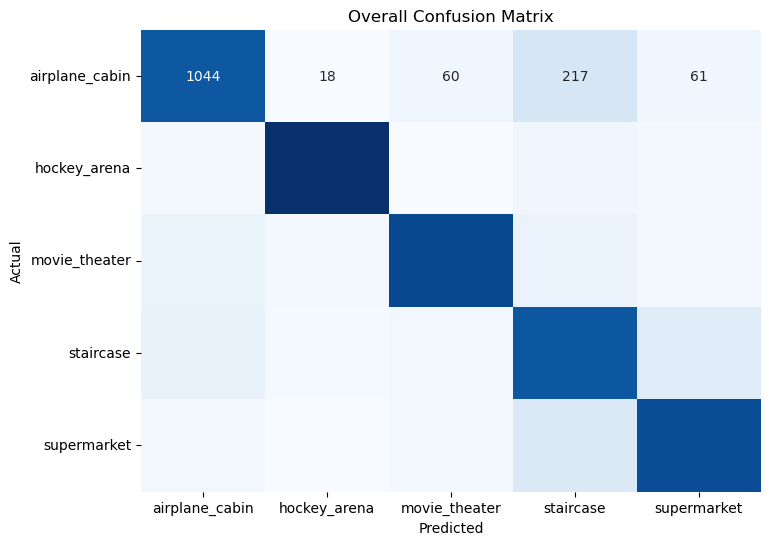

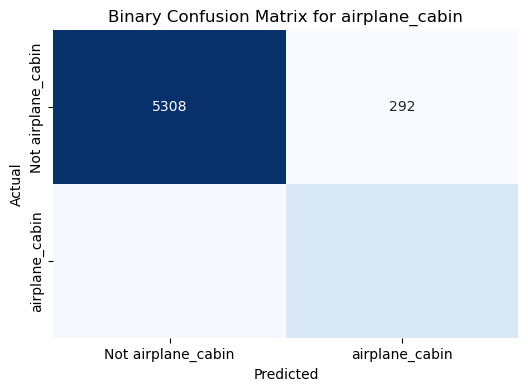

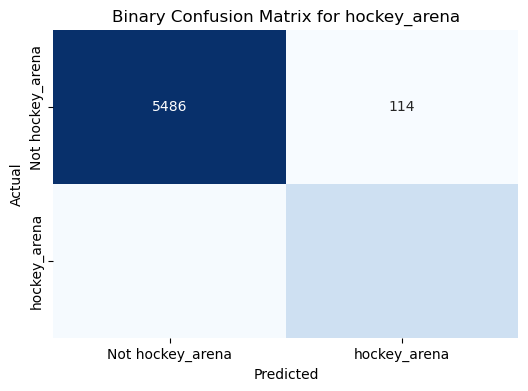

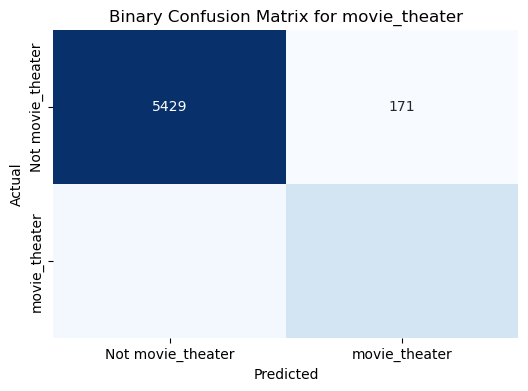

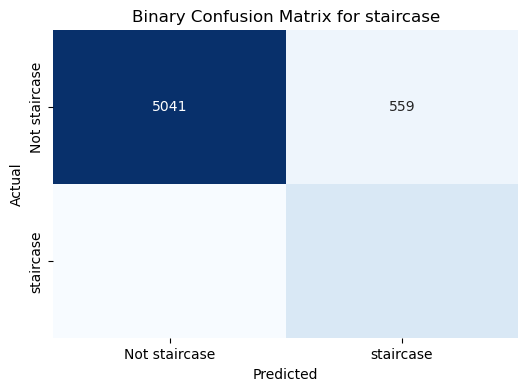

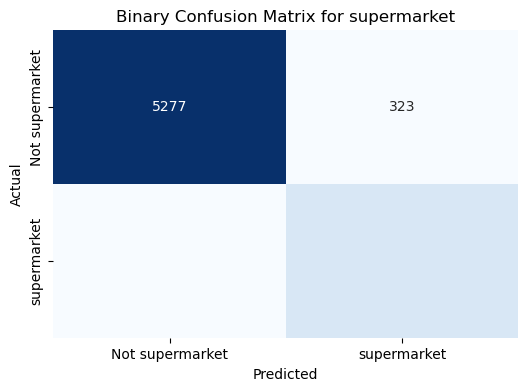

Evaluation on validation set
Accuracy: 0.47
Precision: 0.48
Recall: 0.47
F1-score: 0.47
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       150
           1       0.69      0.71      0.70       150
           2       0.62      0.53      0.58       150
           3       0.26      0.32      0.29       150
           4       0.39      0.33      0.36       150

    accuracy                           0.47       750
   macro avg       0.48      0.47      0.47       750
weighted avg       0.48      0.47      0.47       750

Confusion Matrix:
[[ 66   4  13  43  24]
 [  7 106   3  23  11]
 [ 24  11  80  23  12]
 [ 29  23  18  48  32]
 [ 30  10  14  46  50]]


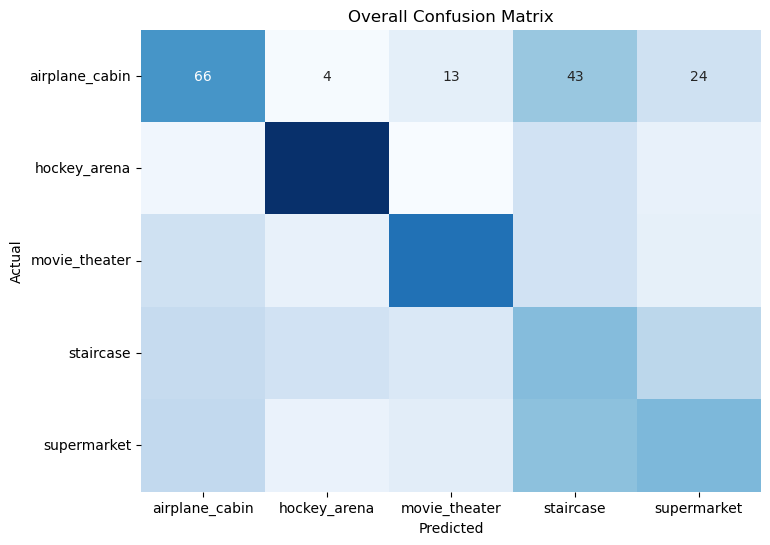

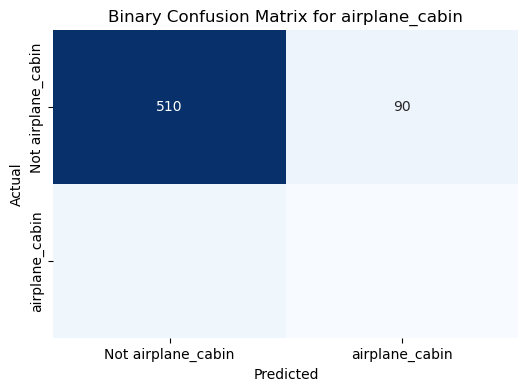

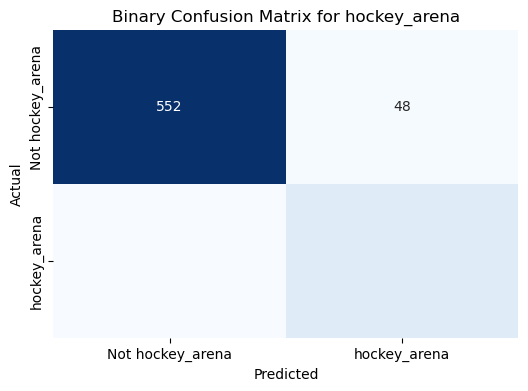

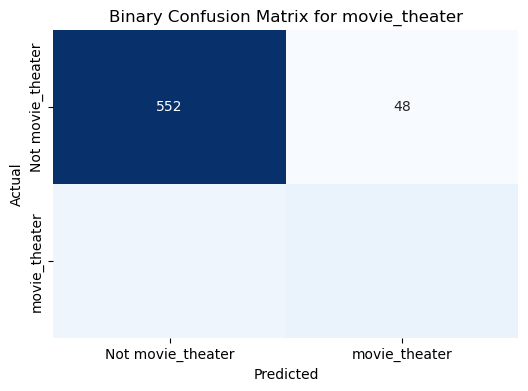

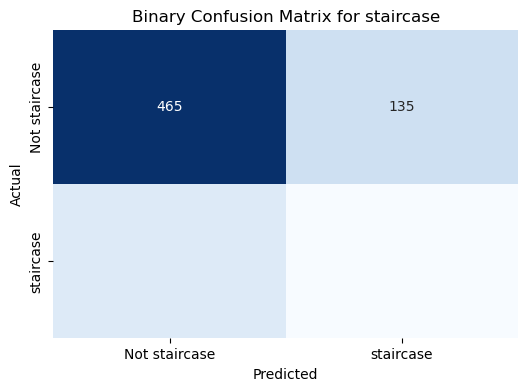

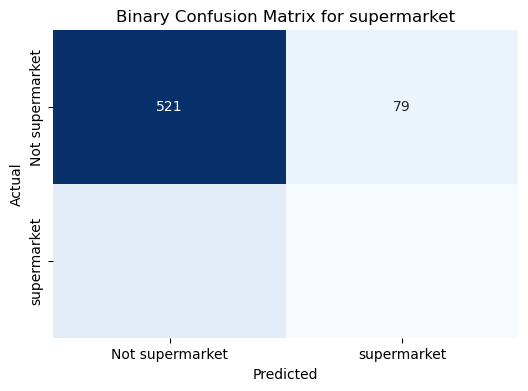

Evaluation on test set
Accuracy: 0.41
Precision: 0.43
Recall: 0.41
F1-score: 0.41
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       150
           1       0.66      0.58      0.62       150
           2       0.57      0.49      0.53       150
           3       0.25      0.31      0.28       150
           4       0.26      0.27      0.27       150

    accuracy                           0.41       750
   macro avg       0.43      0.41      0.41       750
weighted avg       0.43      0.41      0.41       750

Confusion Matrix:
[[55  7 17 44 27]
 [ 6 87  5 19 33]
 [22  8 74 27 19]
 [32 17 15 47 39]
 [26 13 18 52 41]]


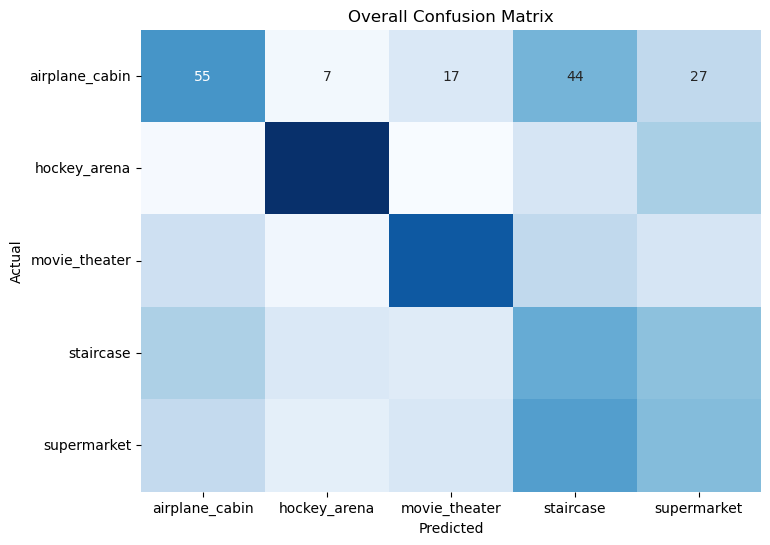

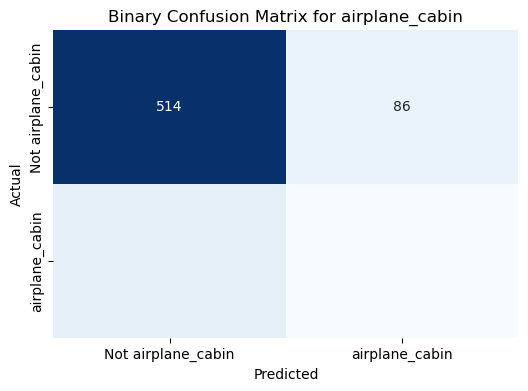

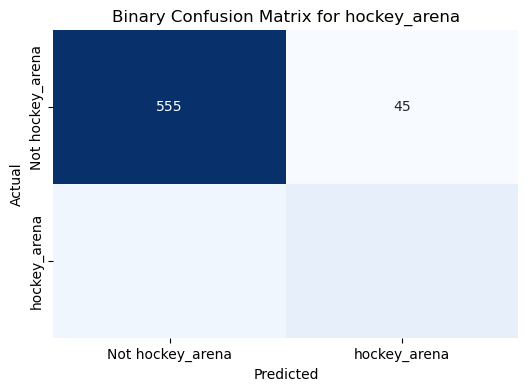

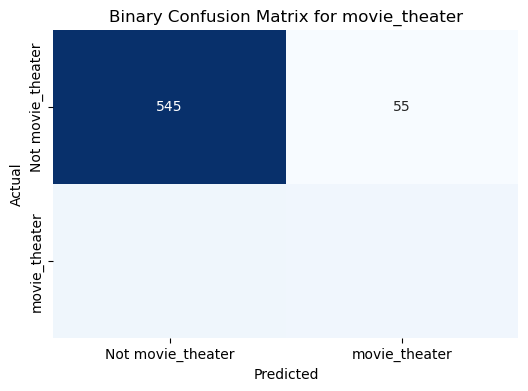

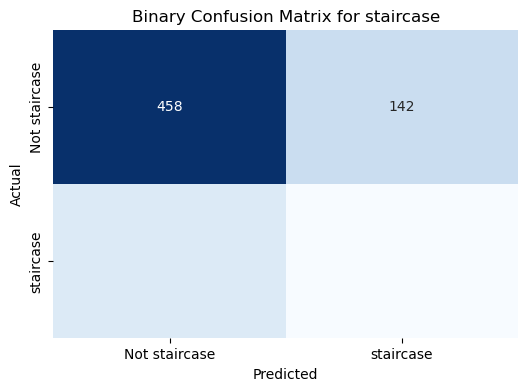

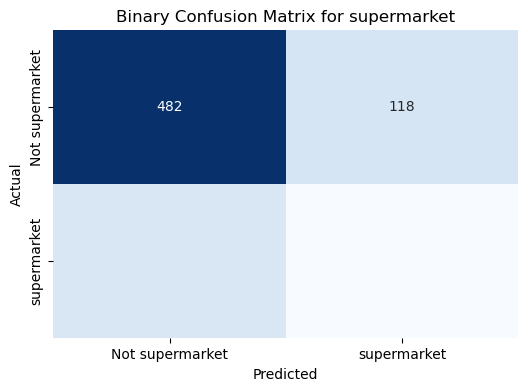

In [36]:
# print and plot the evaluation results
print("Evaluation on training set")
print_evaluation_results(train_results, train_labels, train_predictions)
print("Evaluation on validation set")
print_evaluation_results(val_results, validation_labels, val_predictions)
print("Evaluation on test set")
print_evaluation_results(test_results, test_labels, test_predictions)


# save results in .txt file
hyperparameters = {
                    'max_depth': 10,
                    'min_samples_split': 20,
                    'min_samples_leaf': 2
                }

#save_evaluation_results_to_txt(train_results, output_path_filetest, hyperparameters, 'Training')
#save_evaluation_results_to_txt(val_results, output_path_filetest, hyperparameters, 'Validation')
#save_evaluation_results_to_txt(val_results, output_path_filetest, hyperparameters, 'Testing')

#### ii.b. Test with added features

In [ ]:
# Load training, validation, and test data
train_data, train_labels = load_images_and_labels(TRAIN_DIR)  # with the second load_images_and_labels
validation_data, validation_labels = load_images_and_labels(VALIDATION_DIR)
test_data, test_labels = load_images_and_labels(TEST_DIR)

########## test purpose, please do not delete!


##### basic DT using one set of hyperparameters
# create a decision tree model
model_dt = DecisionTreeClassifier(max_depth=10, 
                                  min_samples_split=20, 
                                  min_samples_leaf=5, 
                                  criterion='entropy', 
                                  random_state=RANDOM_SEED)

# train model
model_dt.fit(train_data, train_labels)

In [ ]:
# evaluate the model on the training set
train_predictions = model_dt.predict(train_data)
train_results = evaluate_model(train_predictions, train_labels)

# evaluate the model on the validation set
val_predictions = model_dt.predict(validation_data)
val_results = evaluate_model(val_predictions, validation_labels)

# evaluate the model on the test set
test_predictions = model_dt.predict(test_data)
test_results = evaluate_model(test_predictions, test_labels)

# print and plot the evaluation results
print_evaluation_results(train_results, train_labels, train_predictions)
print_evaluation_results(val_results, validation_labels, val_predictions)
print_evaluation_results(test_results, test_labels, test_predictions)


# save results in .txt file
hyperparameters = {
                    'max_depth': 10,
                    'min_samples_split': 20,
                    'min_samples_leaf': 5
                }

save_evaluation_results_to_txt(train_results, output_path_file_edge_hog, hyperparameters, 'Training')
save_evaluation_results_to_txt(val_results, output_path_file_edge_hog, hyperparameters, 'Validation')
save_evaluation_results_to_txt(val_results, output_path_file_edge_hog, hyperparameters, 'Testing')

#### ii.c. Some Random Tests with Added Features

In [ ]:
## load and process training data
train_data, train_labels = load_and_process_images(TRAIN_DIR)

In [ ]:
## feature reduction with PCA on the training data

# determine the optimal number of PCA components for the training data
#optimal_components = determine_pca_components(train_data)
#print(f'Optimal number of PCA components: {optimal_components}')


In [ ]:
TRAIN_DATA_PCA = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\saved_models\train_data_pca.npy'
VAL_DATA_PCA = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\saved_models\validation_data_pca.npy'
TEST_DATA_PCA = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\saved_models\test_data_pca.npy'

In [ ]:
# apply PCA to the training data
#pca = PCA(n_components=optimal_components)
#train_data_pca = pca.fit_transform(train_data)
#save_transformed_data(TRAIN_DATA_PCA, train_data_pca)

In [ ]:
# apply the same PCA model to validation data
validation_data, validation_labels = load_and_process_images(VALIDATION_DIR)
#validation_data_pca = apply_pca_to_features(validation_data, pca)
#save_transformed_data(VAL_DATA_PCA, validation_data_pca)

In [ ]:
# apply the same PCA model to test data
test_data, test_labels = load_and_process_images(TEST_DIR)
#test_data_pca = apply_pca_to_features(test_data, pca)
#save_transformed_data(TEST_DATA_PCA, test_data_pca)

### 4.1.1. Grid Search to Find the Set of the Best Hyperparamers

In [ ]:
# define the parameter grid
param_grid = {
    'max_depth': [8, 10],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [5, 10, 15]
}

#### 4.1.1.1. Method 1: GridSearchCV (too slow)

In [ ]:
## method 1: using GridSearchCV from scikitlearn

# create a general DT classifier
gridcv_model_dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

# perform grid search with cross-validation
gridcv_search = GridSearchCV(estimator=gridcv_model_dt, param_grid=param_grid, cv=5, scoring='accuracy')
gridcv_search.fit(train_data, train_labels)

# get the best parameters
best_params = gridcv_search.best_params_

print("Best hyperparameters:", best_params)

# train the model with the best parameters
model_dt = DecisionTreeClassifier(**best_params, criterion='entropy', random_state=RANDOM_SEED)
model_dt.fit(train_data, train_labels)

# use the trained model to predict 
train_predictions_dt = model_dt.predict(train_data)
validation_predictions_dt = model_dt.predict(validation_data)

# evaluate the model using the evaluate_model(predictions, true_labels) function
train_acc_dt, train_prec_dt, train_rec_dt, train_f1_dt, train_conf_matrix_dt, train_report_dt = evaluate_model(train_predictions_dt, train_labels)

val_acc_dt, val_prec_dt, val_rec_dt, val_f1_dt, val_conf_matrix_dt, val_report_dt = evaluate_model(validation_predictions_dt, validation_labels)

# print and plot the evaluation results
print_evaluation_results(train_acc_dt, 
                         train_prec_dt, 
                         train_rec_dt, 
                         train_f1_dt,
                         train_conf_matrix_dt,
                         train_report_dt)

print_evaluation_results(val_acc_dt, 
                         val_prec_dt, 
                         val_rec_dt, 
                         val_f1_dt,
                         val_conf_matrix_dt,
                         val_report_dt)


#### 4.1.1.2. Method 2: Grid Search Without Cross Validation

In [ ]:
def perform_grid_search_without_cv(train_data, train_labels, val_data, val_labels, param_grid, output_path, random_state=RANDOM_SEED):
    """
    Perform grid search without cross-validation to find the best hyperparameters for a Decision Tree classifier.

    Parameters:
    - train_data (array-like): Training data.
    - train_labels (array-like): Labels corresponding to the training data.
    - val_data (array-like): Validation data.
    - val_labels (array-like): Labels corresponding to the validation data.
    - param_grid (dict): Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
    - output_path (str): Path to save the evaluation results.
    - random_state (int): Random seed for reproducibility.

    Outputs:
    - dict: Best hyperparameters found.
    - float: Best accuracy score achieved.
    """

    best_params = None
    best_score = 0

    # Perform grid search without cross-validation
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                # Create a Decision Tree classifier with the current combination of hyperparameters
                model_dt = DecisionTreeClassifier(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    criterion='entropy',
                    random_state=random_state
                )
                
                # Train the model
                model_dt.fit(train_data, train_labels)
                
                # Evaluate the model on the validation set
                val_predictions = model_dt.predict(val_data)
                val_results = evaluate_model(val_predictions, val_labels)
                
                # Evaluate the model on the training set
                train_predictions = model_dt.predict(train_data)
                train_results = evaluate_model(train_predictions, train_labels)

                # Save results to text file
                hyperparameters = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }

                save_evaluation_results_to_txt(train_results, output_path, hyperparameters, 'Training')
                save_evaluation_results_to_txt(val_results, output_path, hyperparameters, 'Validation')
                
                # Update best parameters if the current score is better
                if val_results[0] > best_score:  # val_results[0] is accuracy
                    best_score = val_results[0]
                    best_params = hyperparameters

    return best_params, best_score



In [ ]:
# perform grid search without cross-validation
best_params, best_score = perform_grid_search_without_cv(train_data, 
                                                         train_labels, 
                                                         validation_data, 
                                                         validation_labels, 
                                                         param_grid, 
                                                         output_path)

print("Best hyperparameters without cross-validation:", best_params)
print("Best accuracy score without cross-validation:", best_score)

### Save Predictions in a CSV

In [ ]:
# Save the labels and predictions to a CSV file
results_df = pd.DataFrame({
    'Actual Labels': validation_labels,
    'Predicted Labels': validation_predictions_dt
})

# File path for the CSV file
filename = generate_csv_filename(10, 20, 2, 'entropy')
csv_file_path = os.path.join(PROJECT_OUTPUT_DIR, 'csvs/'+filename)

# Check if the file exists, if not create one, if yes append without writing headers
if not os.path.isfile(csv_file_path):
    results_df.to_csv(csv_file_path, index=False)
else:
    results_df.to_csv(csv_file_path, mode='a', header=False, index=False)

## 4.2. Supervised Decision Tree with 5-fold validation

There is a directory for cross validation.

In [ ]:
def train_decision_tree(train_dir, val_dir):
    """
    Trains a decision tree model using training and validation datasets from specified directories.

    Inputs:
    - train_dir (str): The directory containing the training data.
    - val_dir (str): The directory containing the validation data.

    Outputs:
    - train_accuracy_dtcv (float): The accuracy of the model on the training dataset.
    - vali_accuracy_dtcv (float): The accuracy of the model on the validation dataset.
    """
    # Load images and labels from directories
    train_data, train_labels = load_images_and_labels(train_dir)
    validation_data, validation_labels = load_images_and_labels(val_dir)

    # Define the decision tree model
    model_dtcv = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=5, criterion='entropy', random_state=RANDOM_SEED)
    
    # Train the model
    model_dtcv.fit(train_data, train_labels)
    
    # Evaluate the model using training data
    train_predictions_dtcv = model_dtcv.predict(train_data)
    train_accuracy_dtcv = accuracy_score(train_labels, train_predictions_dtcv)
    
    # Evaluate the model using validation data
    validation_predictions_dtcv = model_dtcv.predict(validation_data)
    vali_accuracy_dtcv = accuracy_score(validation_labels, validation_predictions_dtcv)

    return train_accuracy_dtcv, vali_accuracy_dtcv

def cross_validate_decision_tree(dir):
    """
    Performs a 5-fold cross-validation on a decision tree model using specified directory for data.

    Inputs:
    - dir (str): The directory containing subdirectories for each fold's train and validation data.

    Outputs:
    - Prints the training and validation accuracies for each fold and the average accuracies.
    """
    taccuracies = []
    vaccuracy = []
    
    # Iterate through each of the 5 folds
    for i in range(1, 6):
        train_dir = os.path.join(dir, f'fold_{i}', 'train')
        val_dir = os.path.join(dir, f'fold_{i}', 'val')
        
        # Train and evaluate the decision tree model
        accuracy = train_decision_tree(train_dir, val_dir)
        print(f"Training Accuracy for fold {i}: {accuracy[0]}")
        print(f"Validation Accuracy for fold {i}: {accuracy[1]}")
        
        taccuracies.append(accuracy[0])
        vaccuracy.append(accuracy[1])

    # Print average accuracies
    print(f"Average Training accuracy: {np.mean(taccuracies)}")
    print(f"Average Validation accuracy: {np.mean(vaccuracy)}")


In [ ]:
cross_validate_decision_tree(CV_DIR)

## 4.3. Semi-Supervised Decision Tree

### 4.3.1. Generating the labeled and unlabeled data for Semi-Supervised Decision Tree

In [ ]:
def load_images_and_split(base_dir, labeled_ratio=0.2):
    """
    Load images from a directory, extract features, and split them into labeled and unlabeled datasets.

    Args:
    - base_dir (str): Path to the directory containing subdirectories for each class.
    - labeled_ratio (float): The fraction of data to keep as labeled.

    Returns:
    - labeled_data (np.array): Array of labeled data.
    - labeled_labels (list): List of labels for the labeled data.
    - unlabeled_data (np.array): Array of unlabeled data.
    """
    # Load images and extract features using the existing function
    features_array, labels = load_images_and_labels(base_dir)

    # Split into labeled and unlabeled
    labeled_indices, unlabeled_indices = train_test_split(
        np.arange(len(labels)),
        test_size=1-labeled_ratio,
        random_state=42,  # Ensure reproducibility
        stratify=labels  # Ensure the class distribution is consistent
    )

    labeled_data = features_array[labeled_indices]
    labeled_labels = labels[labeled_indices]
    unlabeled_data = features_array[unlabeled_indices]

    return labeled_data, labeled_labels, unlabeled_data


In [ ]:
labeled_data, labeled_labels, unlabeled_data = load_images_and_split(NO_CV_TRAIN_DIR, labeled_ratio=0.2)
test_data, test_labels = load_images_and_labels(NO_CV_TEST_DIR)

### 4.3.2. Semi-supervised DT Training


In [ ]:
import matplotlib.pyplot as plt

# Create the decision tree model
model_semidt =DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=5, criterion='entropy', random_state= RANDOM_SEED)
    

# Initial training: Use the labeled data to train the model
model_semidt.fit(labeled_data, labeled_labels)

# Threshold list: decrease from 85% to 80% to 75%
thresholds = [0.85, 0.80, 0.75]
test_accuracies = []  # Store the test accuracy for each threshold

count = 0

# Iterate through each threshold
for confidence_threshold in thresholds:
    pseudo_labels = []  # Reset the pseudo label list for each loop

    # Predict the labels for the unlabeled data
    probabilities = model_semidt.predict_proba(unlabeled_data)
    max_probabilities = np.max(probabilities, axis=1)

    # Select high-confidence predictions to use as pseudo labels
    for i, prob in enumerate(max_probabilities):
        if prob > confidence_threshold:
            pseudo_labels.append((unlabeled_data[i], np.argmax(probabilities[i])))
    count = count + len(pseudo_labels)
    print("Added " + str(count) + " images to train." )

    # If there are enough high-confidence predictions, add them as pseudo labels to the training data
    if pseudo_labels:
        pseudo_data, pseudo_labels = zip(*pseudo_labels)
        new_data = np.vstack([labeled_data] + list(pseudo_data))
        new_labels = np.hstack([labeled_labels] + list(pseudo_labels))

        # Retrain the model with the new training data including pseudo labels
        model_semidt.fit(new_data, new_labels)

    # Measure the model's performance on the original labeled test set
    test_accuracy = model_semidt.score(test_data, test_labels)
    test_accuracies.append(test_accuracy)
    print(f'Test Accuracy at threshold {confidence_threshold*100}%: {test_accuracy}')

# Plot the test accuracies
plt.figure(figsize=(10, 6))
plt.plot([str(th*100) for th in thresholds], test_accuracies, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy vs Confidence Threshold')
plt.xlabel('Confidence Threshold (%)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

## 4.4. Semi-Supervised Decision Tree with 5-fold validation

In [ ]:

def train_semi_supervised_decision_tree(train_dir, labeled_ratio, confidence_threshold=0.8):

    """
    Trains a semi-supervised decision tree classifier using labeled and pseudo-labeled data.
    Input:
    - train_dir (str): Directory containing training data.
    - labeled_ratio (float): The fraction of data to keep as labeled.
    - confidence_threshold (float): The probability threshold to accept pseudo-labels.

    Output:
    - model_semi_dtcv (DecisionTreeClassifier): The trained decision tree model.
    """

    # Load labeled and unlabeled data
    labeled_data, labeled_labels, unlabeled_data = load_images_and_split(train_dir, labeled_ratio=labeled_ratio)

    model_semi_dtcv = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=5, criterion='entropy', random_state=RANDOM_SEED)
    model_semi_dtcv.fit(labeled_data, labeled_labels)

    # Use the trained model to predict probabilities for the unlabeled data
    probabilities = model_semi_dtcv.predict_proba(unlabeled_data)
    max_probabilities = np.max(probabilities, axis=1)
    confident_indices = np.where(max_probabilities >= confidence_threshold)[0]

    # Filter pseudo-labels that meet the confidence threshold
    pseudo_labels = model_semi_dtcv.predict(unlabeled_data[confident_indices])

    # Combine the labeled data and high-confidence pseudo-labeled data
    combined_data = np.vstack([labeled_data, unlabeled_data[confident_indices]])
    combined_labels = np.hstack([labeled_labels, pseudo_labels])

    # Retrain the model
    model_semi_dtcv.fit(combined_data, combined_labels)

    return model_semi_dtcv

def cross_validate_semi_supervised_decision_tree(dir, labeled_ratio, confidence_threshold=0.8):
    """
    Performs cross-validation on a semi-supervised decision tree model.

    Inputs:
    - dir (str): Directory containing the data folds for cross-validation.
    - labeled_ratio (float): The fraction of data to keep as labeled.
    - confidence_threshold (float): The probability threshold to accept pseudo-labels.

    Outputs:
    - None, prints the validation accuracies for each fold and the average accuracy.
    """  
    accuracies = []
    for i in range(1, 6):  # 5 folds
        train_dir = os.path.join(dir, f'fold_{i}', 'train')
        val_dir = os.path.join(dir, f'fold_{i}', 'val')
        
        # Train the model using semi-supervised learning
        model = train_semi_supervised_decision_tree(train_dir, labeled_ratio, confidence_threshold)
        # Load validation data
        validation_data, validation_labels = load_images_and_labels(val_dir)
        # Evaluate the model
        val_predictions = model.predict(validation_data)
        accuracy = accuracy_score(validation_labels, val_predictions)
        accuracies.append(accuracy)
        print(f"Validation Accuracy for fold {i}: {accuracy}")

    print(f"Average Validation Accuracy: {np.mean(accuracies)}")



In [ ]:
cross_validate_semi_supervised_decision_tree(CV_DIR, labeled_ratio=0.2, confidence_threshold=0.8)